In [ ]:
import os, sys
import yaml
import torch
import anndata
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from anndata.experimental.pytorch import AnnLoader
from tqdm import trange
from IPython.display import clear_output

%matplotlib inline

In [5]:
sys.path.append('..')

from src.costs import quadratic_cost, l2_squared_cost
from src.plotters import plot_results
from src.regularizers import entropic_regularizer, conservativity_regularizer
from src.mlp import MLPQuadratic

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0x000000); np.random.seed(0x000000)

# Dataset setup

In [7]:
def make_infinite_loader(loader):
    while True:
        for batch in loader:
            yield batch


class CellSampler:
    def __init__(self, ann_data, **loader_kwargs):
        loader = AnnLoader(ann_data, **loader_kwargs)
        self.loader = make_infinite_loader(loader)

    def sample(self):
        return next(self.loader).X.float()

In [8]:
def get_data_pca(dataset, sample_size=1024):
    sampler = CellSampler(dataset, batch_size=sample_size, shuffle=True)
    emb = PCA(n_components=2).fit(sampler.sample().numpy())
    return emb


def get_train_test_datasests(dataset, drug, test_size, random_state=0):
    control_dataset = dataset[dataset.obs.drug == 'control']
    treated_dataset = dataset[dataset.obs.drug == drug]
    control_split = train_test_split(control_dataset, test_size=test_size, random_state=random_state)
    treated_split = train_test_split(treated_dataset, test_size=test_size, random_state=random_state)

    return *control_split, *treated_split

In [9]:
base_path = os.path.join('../', 'experiments_data', '4i')

with open(os.path.join(base_path, 'features.txt')) as features_file:
    features = [line.strip() for line in features_file.readlines()]

dataset = anndata.read_h5ad(os.path.join(base_path, '8h.h5ad'))[:, features]

# Experiment setup

In [10]:
DRUG = 'sorafenib'
FIT_COST = l2_squared_cost
GAP_COST = quadratic_cost

with open(os.path.join(base_path, 'params.yaml')) as params_file:
    experiment_params = yaml.safe_load(params_file)

In [11]:

control_train, control_test, treated_train, treated_test = get_train_test_datasests(dataset, DRUG, experiment_params['test_size'])

emb_control = get_data_pca(control_train)
emb_treated = get_data_pca(treated_train)

init_control_batch_size = int(experiment_params['init_sample_size_factor'] * len(control_train))
init_treated_batch_size = int(experiment_params['init_sample_size_factor'] * len(treated_train))

control_train_sampler = CellSampler(control_train, batch_size=experiment_params['batch_size'], shuffle=True, drop_last=True)
treated_train_sampler = CellSampler(treated_train, batch_size=experiment_params['batch_size'], shuffle=True, drop_last=True)
control_init_sample = CellSampler(control_train, batch_size=init_control_batch_size, shuffle=True, drop_last=True).sample()
treated_init_sample = CellSampler(treated_train, batch_size=init_treated_batch_size, shuffle=True, drop_last=True).sample()

In [12]:
model = MLPQuadratic(len(features), experiment_params['hidden_sizes']).to(device)
model.gaussian_init(
    control_init_sample.to(device),
    treated_init_sample.to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=experiment_params['lr'])
scheduler = torch.optim.lr_scheduler.PolynomialLR(
    optimizer,
    total_iters=experiment_params['n_iters'],
    power=experiment_params['scheduler_power']
)

In [13]:
losses = {
    'Fit loss': [],
    'Monge gap': [],
    'Conservativity loss': [],
    'Total loss': []
}

# Training

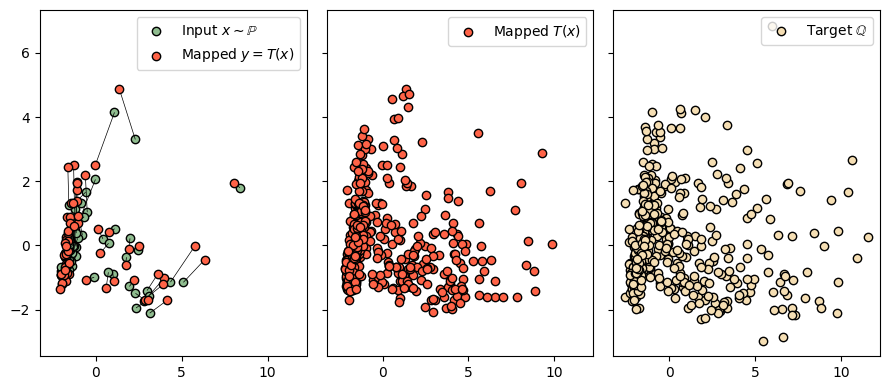

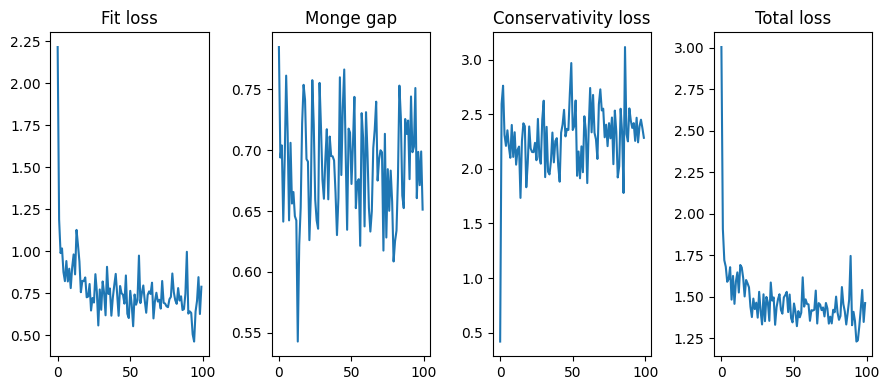

100%|██████████| 10000/10000 [31:10<00:00,  5.35it/s]


In [14]:
log_iters = experiment_params['n_iters'] // 100

for iteration in trange(experiment_params['n_iters']):
    model.train(True)

    X = control_train_sampler.sample().to(device)
    Y = treated_train_sampler.sample().to(device)
    T_X = model(X)

    fit_loss = entropic_regularizer(T_X, Y, FIT_COST)
    monge_gap = GAP_COST(X, T_X).mean() - entropic_regularizer(X, T_X, GAP_COST)
    conservativity_loss = conservativity_regularizer(model.mlp, X)
    loss = fit_loss + experiment_params['monge_gap_regularizer'] * monge_gap + experiment_params['conservativity_regularizer'] * conservativity_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if scheduler.get_last_lr()[0] > experiment_params['min_lr']:
        scheduler.step()

    if iteration % log_iters == 0:
        model.eval()

        clear_output(True)
        losses['Fit loss'].append(fit_loss.item())
        losses['Monge gap'].append(monge_gap.item())
        losses['Conservativity loss'].append(conservativity_loss.item())
        losses['Total loss'].append(loss.item())

        plot_results(X, Y, T_X, losses, emb_control, emb_treated)

# Saving the model

In [16]:
torch.save(model.state_dict(), os.path.join('../', 'checkpoints', '4i', f'{DRUG}_reg.pt'))